# Customer Lifetime Value Prediction and Segmentation


Importing necessary libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import xlrd
import pandas as pd
import datetime
import lifetimes
from lifetimes import BetaGeoFitter,ParetoNBDFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import *
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from math import sqrt
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "darkgrid")

In [2]:
df=pd.read_csv("transaction_data.csv")

## Exploratory Data Analysis

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26,3.39,17850.0,United Kingdom


In [4]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Customer ID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50,4.95,12680.0,France


In [5]:
# Renaming column name

df.rename(columns = {'Customer ID':'CustomerID'}, inplace = True)

In [6]:
df.shape

(541909, 8)

In [7]:
# Checking data types of all columns

df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [9]:
# Dropping rows with duplicates values

df=df.drop_duplicates()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536641 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    536641 non-null  object 
 1   StockCode    536641 non-null  object 
 2   Description  535187 non-null  object 
 3   Quantity     536641 non-null  int64  
 4   InvoiceDate  536641 non-null  object 
 5   UnitPrice    536641 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      536641 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 36.8+ MB


In [11]:
# Checking for null values

df.isnull()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
541904,False,False,False,False,False,False,False,False
541905,False,False,False,False,False,False,False,False
541906,False,False,False,False,False,False,False,False
541907,False,False,False,False,False,False,False,False


In [12]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

In [13]:
# Dropping rows where description == null

df.dropna(axis = 0, subset = ["Description"], inplace = True)

In [14]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133583
Country             0
dtype: int64

In [15]:
# Summary of descriptive statistics

df.describe()

,Quantity,UnitPrice,CustomerID
count,535187.000000,535187.000000,401604.000000
mean,9.671593,4.645242,15281.160818
std,219.059056,97.364810,1714.006089
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13939.000000
50%,3.000000,2.080000,15145.000000
75%,10.000000,4.130000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [16]:
# Dropping the rows where Quantity is negative and considering only positive values

df=df[(df.Quantity>0)]

In [17]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,525462.000000,525462.000000,392732.000000
mean,10.681024,3.876109,15287.734822
std,157.399272,42.040021,1713.567773
min,1.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13955.000000
50%,4.000000,2.080000,15150.000000
75%,11.000000,4.130000,16791.000000
max,80995.000000,13541.330000,18287.000000


Dropping the rows where the Customer id == null. 
We have to drop the rows where customer ID is null because it's a unique customer ID of each customer. So it's better to drop rather than imputing it with some random value

In [18]:
# dropping the rows where the Customer ID is null
#df=df[(df.CustomerID.isnull()== False)]

df.dropna(axis = 0, subset = ["CustomerID"], inplace = True)

In [19]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,392732.000000,392732.000000,392732.000000
mean,13.153718,3.125596,15287.734822
std,181.588420,22.240725,1713.567773
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


In [20]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [21]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34,1.69,13047.0,United Kingdom


In [22]:
df.shape

(392732, 8)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392732 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    392732 non-null  object 
 1   StockCode    392732 non-null  object 
 2   Description  392732 non-null  object 
 3   Quantity     392732 non-null  int64  
 4   InvoiceDate  392732 non-null  object 
 5   UnitPrice    392732 non-null  float64
 6   CustomerID   392732 non-null  float64
 7   Country      392732 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.0+ MB


In [24]:
# Checking no. of unique customers

df['CustomerID'].nunique()

4339

In [25]:
# Finding length of rows where quantity == 0

len(df[df.Quantity<0])

0

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392732 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    392732 non-null  object 
 1   StockCode    392732 non-null  object 
 2   Description  392732 non-null  object 
 3   Quantity     392732 non-null  int64  
 4   InvoiceDate  392732 non-null  object 
 5   UnitPrice    392732 non-null  float64
 6   CustomerID   392732 non-null  float64
 7   Country      392732 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.0+ MB


In [27]:
# Date Extraction (Converting datetime to object)

df['InvoiceDate']=pd.to_datetime(df['InvoiceDate']).dt.date

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392732 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    392732 non-null  object 
 1   StockCode    392732 non-null  object 
 2   Description  392732 non-null  object 
 3   Quantity     392732 non-null  int64  
 4   InvoiceDate  392732 non-null  object 
 5   UnitPrice    392732 non-null  float64
 6   CustomerID   392732 non-null  float64
 7   Country      392732 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.0+ MB


### Feature generation (Amount column)

In [29]:
df['Amount']=df['Quantity']*df['UnitPrice']

In [30]:
# Checking Data type of InvoiceDate column

df['InvoiceDate'].dtypes

dtype('O')

In [31]:
df.describe()


,Quantity,UnitPrice,CustomerID,Amount
count,392732.000000,392732.000000,392732.000000,392732.000000
mean,13.153718,3.125596,15287.734822,22.629195
std,181.588420,22.240725,1713.567773,311.083465
min,1.000000,0.000000,12346.000000,0.000000
25%,2.000000,1.250000,13955.000000,4.950000
50%,6.000000,1.950000,15150.000000,12.390000
75%,12.000000,3.750000,16791.000000,19.800000
max,80995.000000,8142.750000,18287.000000,168469.600000


# Feature Generation
## RFMT Estimation - (Recency, Frequency, Monetary value, Tenure)

A) **T** -  T is the length of the period of observation for the customer based on the value used for freq (the default is frequency is day). This can also be thought of the length of time between a customer’s first purchase and the end of the period, measured in increments defined by freq.

B) **Recency** - Recency is the point (relative to their own period of observation) at which the customer made their most recent repeat purchase. This can also be thought of the length of time between a customer’s first and last purchase for the period, measured in increments defined by freq.

C) **Frequency** - Frequency is the number of repeat purchases the customer made during the observation period.

D) **Monetary** - monetary_value is the average monetary amount of each repeat purchase made by a customer.

In [32]:
rfmt_data=lifetimes.utils.summary_data_from_transaction_data(df,'CustomerID','InvoiceDate',monetary_value_col='Amount')

In [33]:
rfmt_data.describe()

,frequency,recency,T,monetary_value
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,2.864024,130.741415,222.782899,305.964829
std,5.952745,132.210176,117.883623,2612.357160
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,112.000000,0.000000
50%,1.000000,93.000000,248.000000,175.860000
75%,3.000000,252.000000,326.000000,358.627500
max,131.000000,373.000000,373.000000,168469.600000


In [34]:
rfmt_data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


### Frequency Histogram plot

<Axes: ylabel='Frequency'>

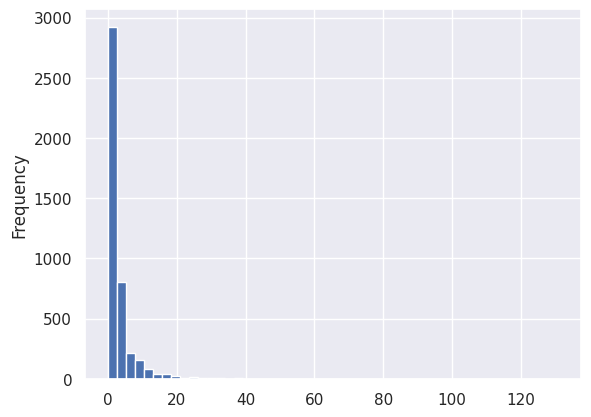

In [35]:
rfmt_data['frequency'].plot(kind='hist',bins=50)

In [36]:
print(sum(rfmt_data['frequency']==0)/float(len(rfmt_data)))

0.3569946992394561


In [37]:
rfmt_data.describe()

,frequency,recency,T,monetary_value
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,2.864024,130.741415,222.782899,305.964829
std,5.952745,132.210176,117.883623,2612.357160
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,112.000000,0.000000
50%,1.000000,93.000000,248.000000,175.860000
75%,3.000000,252.000000,326.000000,358.627500
max,131.000000,373.000000,373.000000,168469.600000


In [38]:
# Checking for the values containing zero.

print("Total Number of Frequency with 0: %s" % (len(rfmt_data[rfmt_data["frequency"] == 0])))
print("Total Number of Recency with 0: %s" % (len(rfmt_data[rfmt_data["recency"] == 0])))
print("Total Number of Monetary Value with 0: %s" % (len(rfmt_data[rfmt_data["monetary_value"] == 0])))

Total Number of Frequency with 0: 1549
Total Number of Recency with 0: 1549
Total Number of Monetary Value with 0: 1549


## Model Building

## Beta Geo - Negative Binomial Distribution + Gamma Gamma Distribution Model

In [39]:
summary_bgf=rfmt_data.copy()

In [40]:
summary_bgf.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


In [41]:
bgf=BetaGeoFitter(penalizer_coef=0.0)

In [42]:
bgf.fit(rfmt_data['frequency'],rfmt_data['recency'],rfmt_data['T'])

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>

In [43]:
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

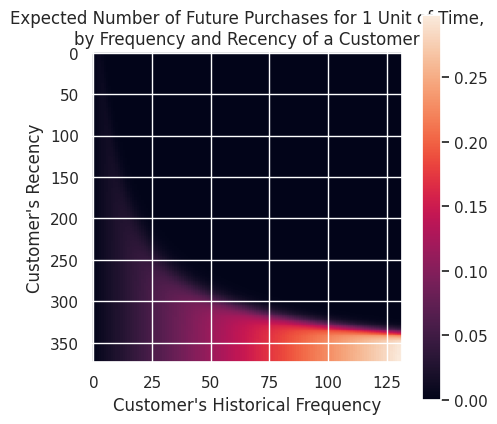

In [44]:
# Plotting the frequency and recency matrix

plt.figure(figsize=(5,5))
plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

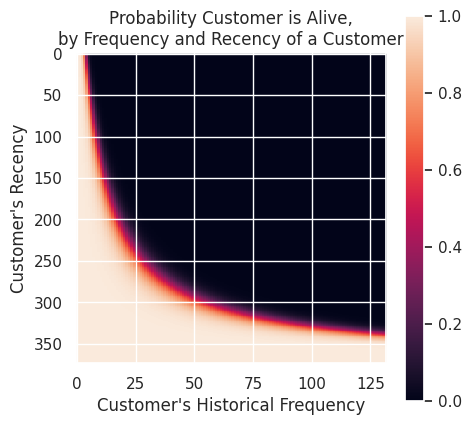

In [45]:
# Plotting the churn matrix (Probability alive)

plt.figure(figsize=(5,5))
plot_probability_alive_matrix(bgf)

### Feature Generation (Predicted purchases for 30 days)

In [46]:
t=30
summary_bgf['predicted_purchases']=bgf.conditional_expected_number_of_purchases_up_to_time(t,rfmt_data['frequency'],rfmt_data['recency'],rfmt_data['T'])

In [47]:
summary_bgf.tail()

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
18280.0,0.0,0.0,277.0,0.000000,0.071676
18281.0,0.0,0.0,180.0,0.000000,0.099608
18282.0,1.0,119.0,126.0,77.840000,0.280968
18283.0,13.0,334.0,337.0,149.006154,1.021629
18287.0,2.0,159.0,201.0,536.000000,0.313925


In [48]:
summary_bgf.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,372.0,373.0,134.975341,6.029510
15311.0,89.0,373.0,373.0,676.210899,6.097442
17841.0,111.0,372.0,373.0,360.246937,7.590787
12748.0,113.0,373.0,373.0,292.462301,7.726616
14911.0,131.0,372.0,373.0,1092.792290,8.948418


In [49]:
summary_bgf.sort_values(by='predicted_purchases').head(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
18074.0,0.0,0.0,373.0,0.0,0.056105
16048.0,0.0,0.0,373.0,0.0,0.056105
16274.0,0.0,0.0,373.0,0.0,0.056105
14237.0,0.0,0.0,373.0,0.0,0.056105
14142.0,0.0,0.0,373.0,0.0,0.056105


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

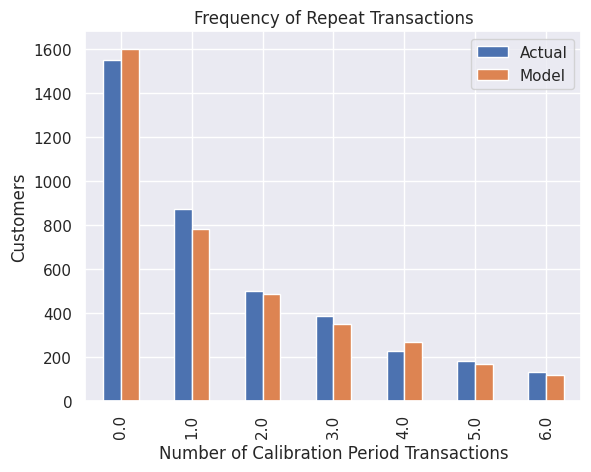

In [50]:
# Actual Purchases vs Predicted Purchases

plot_period_transactions(bgf)

### Dividing our dataset into Training (Calibration) & Testing (holdout)

In [51]:
summary_cal_holdout=calibration_and_holdout_data(df,'CustomerID','InvoiceDate',calibration_period_end='2011-06-08',observation_period_end='2011-12-09')

In [52]:
pd.DataFrame(summary_cal_holdout.head())

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.0,0.0,0.0,141.0,0.0,184.0
12347.0,2.0,121.0,183.0,4.0,184.0
12348.0,2.0,110.0,174.0,1.0,184.0
12350.0,0.0,0.0,126.0,0.0,184.0
12352.0,3.0,34.0,112.0,3.0,184.0


In [53]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])


<lifetimes.BetaGeoFitter: fitted with 2787 subjects, a: 0.00, alpha: 61.78, b: 14334.05, r: 0.74>

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

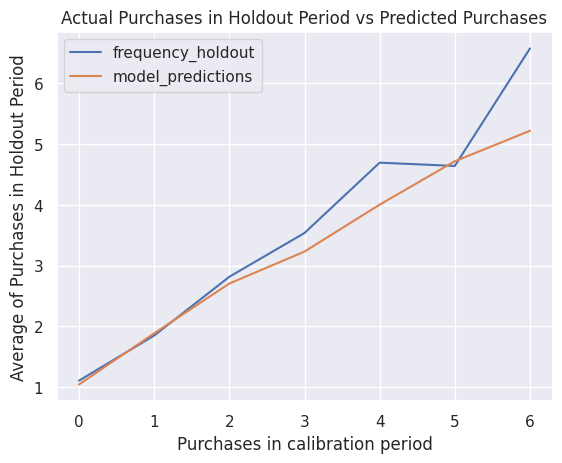

In [54]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

### Feature Generation (Actual Purchases for 30 days)

In [55]:
summary_bgf["actual_purchases"] = summary_bgf["frequency"]/summary_bgf["recency"]*30

In [56]:
summary_bgf.tail()

,frequency,recency,T,monetary_value,predicted_purchases,actual_purchases
CustomerID,,,,,,
18280.0,0.0,0.0,277.0,0.000000,0.071676,NaN
18281.0,0.0,0.0,180.0,0.000000,0.099608,NaN
18282.0,1.0,119.0,126.0,77.840000,0.280968,0.252101
18283.0,13.0,334.0,337.0,149.006154,1.021629,1.167665
18287.0,2.0,159.0,201.0,536.000000,0.313925,0.377358


In [57]:
summary_bgf = summary_bgf.fillna(value = 0) #filling null values with 0

In [58]:
summary_bgf.head()

,frequency,recency,T,monetary_value,predicted_purchases,actual_purchases
CustomerID,,,,,,
12346.0,0.0,0.0,325.0,0.000000,0.062942,0.000000
12347.0,6.0,365.0,367.0,599.701667,0.469651,0.493151
12348.0,3.0,283.0,358.0,301.480000,0.268668,0.318021
12349.0,0.0,0.0,18.0,0.000000,0.285291,0.000000
12350.0,0.0,0.0,310.0,0.000000,0.065433,0.000000


In [59]:
#Filtering the data where we have the values of 0 or less than 0.

summary_ = summary_bgf[(summary_bgf["monetary_value"] > 0) & (summary_bgf["frequency"] > 0)]


<Axes: >

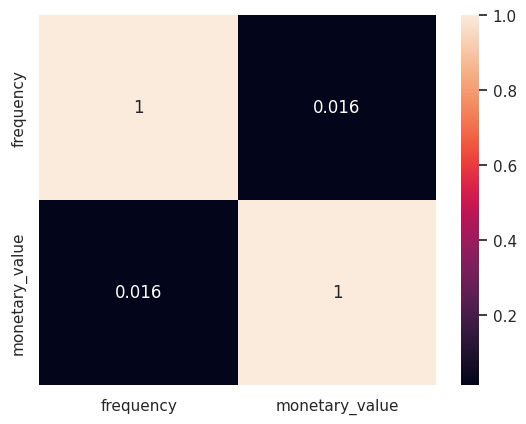

In [60]:
# sns.heatmap(final_summary[["frequency", "monetary_value"]].corr(), annot = True)
sns.heatmap(summary_[["frequency", "monetary_value"]].corr(), annot = True)

To proceed with the Gamma Gamma Model we have to check for the assumption whether the frequency and monetary values are intercorrelated or not. As we can see here, the correlation between the frequency and monetary value is pretty low so we can go ahead to build Gamma Gamma Model.

In [61]:
ggf = lifetimes.GammaGammaFitter(penalizer_coef = 0.0)

In [62]:
ggf.fit(summary_["frequency"], summary_["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.11, q: 3.44, v: 479.30>

summary_ = summary_bgf[(summary_bgf["monetary_value"] > 0) & (summary_bgf["frequency"] > 0)]

In [63]:
summary_.shape

(2790, 6)

### Feature Generation (Expected Average Sales)

In [64]:
summary_["Expected_Avg_Sales"] = ggf.conditional_expected_average_profit(summary_["frequency"], 
                                                                        summary_["monetary_value"])

In [65]:
summary_.head()

,frequency,recency,T,monetary_value,predicted_purchases,actual_purchases,Expected_Avg_Sales
CustomerID,,,,,,,
12347.0,6.0,365.0,367.0,599.701667,0.469651,0.493151,569.963180
12348.0,3.0,283.0,358.0,301.480000,0.268668,0.318021,333.111656
12352.0,6.0,260.0,296.0,368.256667,0.560863,0.692308,375.852105
12356.0,2.0,303.0,325.0,269.905000,0.215146,0.198020,323.118513
12358.0,1.0,149.0,150.0,683.200000,0.250171,0.201342,539.696607


### CLV Prediction using BGNBD & Gamma Gamma Model

In [66]:
summary_["predicted_clv"] = ggf.customer_lifetime_value(bgf,
                                                       summary_["frequency"],
                                                       summary_["recency"],
                                                       summary_["T"],
                                                       summary_["monetary_value"],
                                                       time = 30,
                                                       freq = 'D',
                                                       discount_rate = 0.01)

In [67]:
summary_.head()

,frequency,recency,T,monetary_value,predicted_purchases,actual_purchases,Expected_Avg_Sales,predicted_clv
CustomerID,,,,,,,,
12347.0,6.0,365.0,367.0,599.701667,0.469651,0.493151,569.963180,6940.390693
12348.0,3.0,283.0,358.0,301.480000,0.268668,0.318021,333.111656,2300.087160
12352.0,6.0,260.0,296.0,368.256667,0.560863,0.692308,375.852105,5484.949898
12356.0,2.0,303.0,325.0,269.905000,0.215146,0.198020,323.118513,1774.643444
12358.0,1.0,149.0,150.0,683.200000,0.250171,0.201342,539.696607,3440.461674


### Model Evaluation (BGNBD)

In [68]:
summary_cal_holdout['Predicted_purchases_holdout']=bgf.conditional_expected_number_of_purchases_up_to_time(184,summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
actual_purchases_holdout=summary_cal_holdout['frequency_holdout']
predicted_purchases_holdout=summary_cal_holdout['Predicted_purchases_holdout']

In [69]:
bgf_mae_purchase= mean_absolute_error(actual_purchases_holdout,predicted_purchases_holdout)
bgf_mse_purchase = mean_squared_error(actual_purchases_holdout,predicted_purchases_holdout)
bgf_rmse_purchase = sqrt(bgf_mse_purchase)
bgf_avg_error_purchase_30 = (actual_purchases_holdout - predicted_purchases_holdout).mean()
r2 = r2_score(actual_purchases_holdout,predicted_purchases_holdout)


print(f"MAE: {bgf_mae_purchase}")
print(f"MSE: {bgf_mse_purchase}")
print(f"RMSE: {bgf_rmse_purchase}")
print(f"R2 Error: {r2}")

MAE: 1.5122589395237092
MSE: 6.443055074026868
RMSE: 2.53831737062702
R2 Error: 0.6221461838752695


## Pareto - Negative Binomial Distribution + Gamma Gamma Distribution Model

In [70]:
summary_pnbd=rfmt_data.copy()

In [71]:
summary_pnbd.shape

(4339, 4)

In [72]:
rfmt_data.shape

(4339, 4)

In [73]:
summary_pnbd.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


In [74]:
pareto_nbd = ParetoNBDFitter(penalizer_coef = 0.0)
pareto_nbd.fit(summary_pnbd["frequency"], summary_pnbd["recency"], summary_pnbd["T"])

<lifetimes.ParetoNBDFitter: fitted with 4339 subjects, alpha: 69.08, beta: 821.12, r: 0.83, s: 0.00>

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

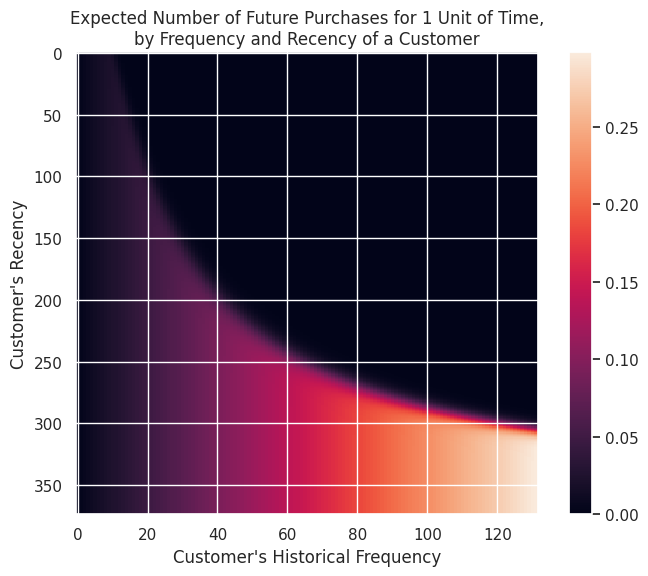

In [75]:
plt.figure(figsize=(8,6))
plot_frequency_recency_matrix(pareto_nbd)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

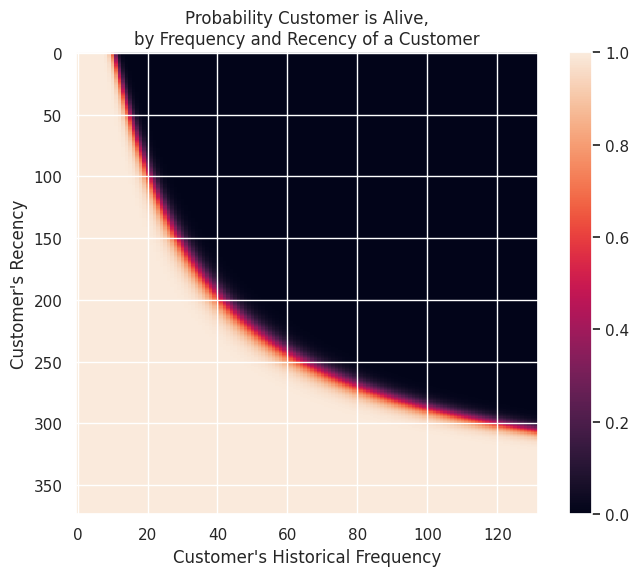

In [76]:
plt.figure(figsize=(8,6))
plot_probability_alive_matrix(pareto_nbd)

In [77]:
summary_pnbd["p_not_alive"] = 1-pareto_nbd.conditional_probability_alive(summary_pnbd["frequency"], summary_pnbd["recency"], summary_pnbd["T"])
summary_pnbd["p_alive"] = pareto_nbd.conditional_probability_alive(summary_pnbd["frequency"], summary_pnbd["recency"], summary_pnbd["T"])

### Feature Generation (predicted purchases for 30 days)

In [78]:
t = 30
summary_pnbd["predicted_purchases"] = pareto_nbd.conditional_expected_number_of_purchases_up_to_time(t, summary_pnbd["frequency"], summary_pnbd["recency"], summary_pnbd["T"])

In [79]:
summary_pnbd.tail()

,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases
CustomerID,,,,,,,
18280.0,0.0,0.0,277.0,0.000000,7.142464e-08,1.0,0.071723
18281.0,0.0,0.0,180.0,0.000000,4.349612e-08,1.0,0.099654
18282.0,1.0,119.0,126.0,77.840000,1.039332e-09,1.0,0.281025
18283.0,13.0,334.0,337.0,149.006154,3.700906e-10,1.0,1.021533
18287.0,2.0,159.0,201.0,536.000000,7.252259e-09,1.0,0.314064


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

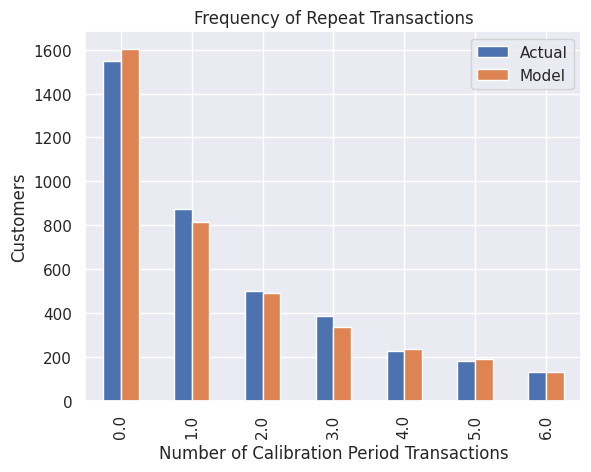

In [80]:
plot_period_transactions(pareto_nbd)

### Dividing our dataset into training & holdout

In [81]:
pareto_summary_cal_holdout = calibration_and_holdout_data(df, "CustomerID", "InvoiceDate", 
                                                   calibration_period_end = '2011-06-08',
                                                  observation_period_end = '2011-12-09')

In [82]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.0,0.0,0.0,141.0,0.0,184.0
12347.0,2.0,121.0,183.0,4.0,184.0
12348.0,2.0,110.0,174.0,1.0,184.0
12350.0,0.0,0.0,126.0,0.0,184.0
12352.0,3.0,34.0,112.0,3.0,184.0


In [83]:
pareto_nbd.fit(pareto_summary_cal_holdout["frequency_cal"],
               pareto_summary_cal_holdout["recency_cal"],
               pareto_summary_cal_holdout["T_cal"])

<lifetimes.ParetoNBDFitter: fitted with 2787 subjects, alpha: 61.78, beta: 986.07, r: 0.74, s: 0.00>

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

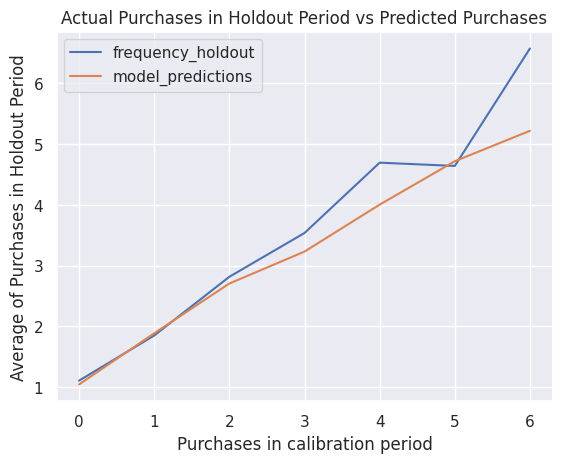

In [84]:
plot_calibration_purchases_vs_holdout_purchases(pareto_nbd, pareto_summary_cal_holdout)

### Feature Generation (Actual Purchases for 30 days)

In [85]:
summary_pnbd["actual_purchases"] = summary_pnbd["frequency"]/summary_pnbd["recency"]*30

In [86]:
summary_pnbd.head()

,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual_purchases
CustomerID,,,,,,,,
12346.0,0.0,0.0,325.0,0.000000,8.564317e-08,1.0,0.062987,NaN
12347.0,6.0,365.0,367.0,599.701667,2.319025e-10,1.0,0.469691,0.493151
12348.0,3.0,283.0,358.0,301.480000,1.307946e-08,1.0,0.268854,0.318021
12349.0,0.0,0.0,18.0,0.000000,3.227778e-09,1.0,0.285053,NaN
12350.0,0.0,0.0,310.0,0.000000,8.118038e-08,1.0,0.065479,NaN


In [87]:
# Putting zero in places where NA in actual_purchases

summary_pnbd["actual_purchases"].fillna(0, inplace = True)

In [88]:
print("Mean Squared Error: %s" % mean_squared_error(summary_pnbd["actual_purchases"], summary_pnbd["predicted_purchases"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(summary_pnbd["actual_purchases"], summary_pnbd["predicted_purchases"])))


Mean Squared Error: 2.6917337257028735
Root Mean Squared Error: 1.64065039716049


In [89]:
summary_pnbd.head()

,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual_purchases
CustomerID,,,,,,,,
12346.0,0.0,0.0,325.0,0.000000,8.564317e-08,1.0,0.062987,0.000000
12347.0,6.0,365.0,367.0,599.701667,2.319025e-10,1.0,0.469691,0.493151
12348.0,3.0,283.0,358.0,301.480000,1.307946e-08,1.0,0.268854,0.318021
12349.0,0.0,0.0,18.0,0.000000,3.227778e-09,1.0,0.285053,0.000000
12350.0,0.0,0.0,310.0,0.000000,8.118038e-08,1.0,0.065479,0.000000


In [90]:
summary_copy = summary_pnbd.copy()

In [91]:
summary_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4339 entries, 12346.0 to 18287.0
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   frequency            4339 non-null   float64
 1   recency              4339 non-null   float64
 2   T                    4339 non-null   float64
 3   monetary_value       4339 non-null   float64
 4   p_not_alive          4339 non-null   float64
 5   p_alive              4339 non-null   float64
 6   predicted_purchases  4339 non-null   float64
 7   actual_purchases     4339 non-null   float64
dtypes: float64(8)
memory usage: 305.1 KB


In [92]:
summary_copy = summary_copy[(summary_copy["frequency"] > 0) & (summary_copy["monetary_value"] > 0)]

In [93]:
summary_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2790 entries, 12347.0 to 18287.0
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   frequency            2790 non-null   float64
 1   recency              2790 non-null   float64
 2   T                    2790 non-null   float64
 3   monetary_value       2790 non-null   float64
 4   p_not_alive          2790 non-null   float64
 5   p_alive              2790 non-null   float64
 6   predicted_purchases  2790 non-null   float64
 7   actual_purchases     2790 non-null   float64
dtypes: float64(8)
memory usage: 196.2 KB


<Axes: >

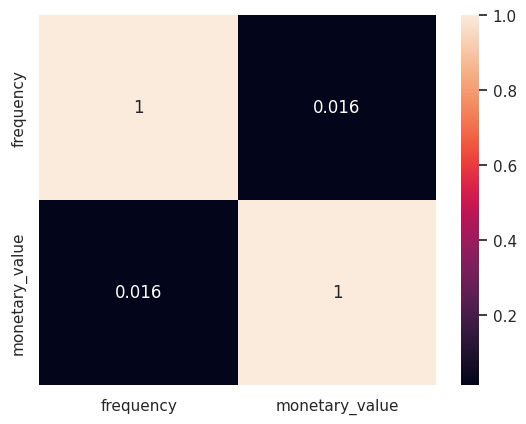

In [94]:
sns.heatmap(summary_copy[["frequency", "monetary_value"]].corr(), annot = True)

In [95]:
ggf_p = lifetimes.GammaGammaFitter(penalizer_coef = 0.0)

In [96]:
ggf_p.fit(summary_copy["frequency"], summary_copy["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.11, q: 3.44, v: 479.30>

In [97]:
summary_copy["expected_avg_sales_p"] = ggf_p.conditional_expected_average_profit(summary_copy["frequency"],
                                                                        summary_copy["monetary_value"])

In [98]:
summary_copy.head()

,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual_purchases,expected_avg_sales_p
CustomerID,,,,,,,,,
12347.0,6.0,365.0,367.0,599.701667,2.319025e-10,1.0,0.469691,0.493151,569.963180
12348.0,3.0,283.0,358.0,301.480000,1.307946e-08,1.0,0.268854,0.318021,333.111656
12352.0,6.0,260.0,296.0,368.256667,6.432683e-09,1.0,0.561036,0.692308,375.852105
12356.0,2.0,303.0,325.0,269.905000,2.850083e-09,1.0,0.215241,0.198020,323.118513
12358.0,1.0,149.0,150.0,683.200000,1.401868e-10,1.0,0.250239,0.201342,539.696607


### CLV Prediction using ParetoNBD

In [99]:
summary_copy["predicted_clv_p"] = ggf_p.customer_lifetime_value(pareto_nbd,
                                                       summary_copy["frequency"],
                                                       summary_copy["recency"],
                                                       summary_copy["T"],
                                                       summary_copy["monetary_value"],
                                                       time = 30,
                                                       freq = 'D',
                                                       discount_rate = 0.01)

In [100]:
summary_copy.shape

(2790, 10)

In [101]:
summary_copy.head()

,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual_purchases,expected_avg_sales_p,predicted_clv_p
CustomerID,,,,,,,,,,
12347.0,6.0,365.0,367.0,599.701667,2.319025e-10,1.0,0.469691,0.493151,569.963180,6940.391335
12348.0,3.0,283.0,358.0,301.480000,1.307946e-08,1.0,0.268854,0.318021,333.111656,2300.084986
12352.0,6.0,260.0,296.0,368.256667,6.432683e-09,1.0,0.561036,0.692308,375.852105,5484.951958
12356.0,2.0,303.0,325.0,269.905000,2.850083e-09,1.0,0.215241,0.198020,323.118513,1774.640434
12358.0,1.0,149.0,150.0,683.200000,1.401868e-10,1.0,0.250239,0.201342,539.696607,3440.453870


### Model Evaluation (Pareto NBD)

In [102]:
pareto_mae_purchase = mean_absolute_error(summary_copy["actual_purchases"], summary_copy["predicted_purchases"])
pareto_mse_purchase = mean_squared_error(summary_copy["actual_purchases"], summary_copy["predicted_purchases"])
pareto_rmse_purchase = sqrt(mean_squared_error(summary_copy["actual_purchases"], summary_copy["predicted_purchases"]))
r2_p = r2_score(summary_copy['monetary_value'], summary_copy['expected_avg_sales_p'])



print(f"MAE: {pareto_mae_purchase}")
print(f"MSE: {pareto_mse_purchase}")
print(f"RMSE: {pareto_rmse_purchase}")
print(f"R² error: {r2_p}")

MAE: 0.4315258779201045
MSE: 4.170311124476023
RMSE: 2.042133963401036
R² error: 0.7174698927670047


### Predicted CLV summary

In [103]:
summary_ = summary_.reset_index()
summary_copy = summary_copy.reset_index()

In [104]:
predicted_clv_results = pd.DataFrame(summary_[["CustomerID", "predicted_clv"]])
predicted_clv_results = predicted_clv_results.merge(summary_copy[["CustomerID", "predicted_clv_p"]], on = "CustomerID")
predicted_clv_results.columns = ["CustomerID", "BG-NBD_CLV", "Pareto-NBD_CLV"]

In [105]:
predicted_clv_results.head(5)

,CustomerID,BG-NBD_CLV,Pareto-NBD_CLV
0,12347.0,6940.390693,6940.391335
1,12348.0,2300.087160,2300.084986
2,12352.0,5484.949898,5484.951958
3,12356.0,1774.643444,1774.640434
4,12358.0,3440.461674,3440.453870


In [106]:
#predicted_clv_results.to_csv("Predicted CLV Results.csv")

## Model Evaluation Summary

In [107]:
data = [[bgf_mae_purchase,pareto_mae_purchase],[bgf_mse_purchase, pareto_mse_purchase],
[bgf_rmse_purchase, pareto_rmse_purchase], [r2, r2_p]]




In [108]:
indexes = ["MAE Error", "MSE Error","RMSE Error","R2 Error"]

In [109]:
model_result = pd.DataFrame(data, columns = ["BG-NBD", "Pareto-NBD"], index = indexes)

In [110]:
model_result

,BG-NBD,Pareto-NBD
MAE Error,1.512259,0.431526
MSE Error,6.443055,4.170311
RMSE Error,2.538317,2.042134
R2 Error,0.622146,0.717470


## Customer Segmentation using KMeans

In [159]:
ggf_filter=summary_copy.copy()

In [160]:
ggf_filter[["CustomerID", "predicted_clv_p"]].sort_values(by = "predicted_clv_p", ascending = False).head(5)

,CustomerID,predicted_clv_p
1111,14646.0,517790.523165
2706,18102.0,416281.984974
1938,16446.0,396924.215411
2413,17450.0,342945.717741
834,14096.0,304656.549751


In [161]:
ggf_filter["profit_margin"] = ggf_filter["predicted_clv_p"]*0.05

In [162]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

In [163]:
ggf_filter.to_csv("customer_lifetime_value_prediction.csv")

In [164]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual_purchases,expected_avg_sales_p,predicted_clv_p,profit_margin
0,12347.0,6.0,365.0,367.0,599.701667,2.319025e-10,1.0,0.469691,0.493151,569.963180,6940.391335,347.019567
1,12348.0,3.0,283.0,358.0,301.480000,1.307946e-08,1.0,0.268854,0.318021,333.111656,2300.084986,115.004249
2,12352.0,6.0,260.0,296.0,368.256667,6.432683e-09,1.0,0.561036,0.692308,375.852105,5484.951958,274.247598
3,12356.0,2.0,303.0,325.0,269.905000,2.850083e-09,1.0,0.215241,0.198020,323.118513,1774.640434,88.732022
4,12358.0,1.0,149.0,150.0,683.200000,1.401868e-10,1.0,0.250239,0.201342,539.696607,3440.453870,172.022694


In [165]:
col = ["predicted_purchases", "expected_avg_sales_p", "predicted_clv_p", "profit_margin"]

In [166]:
new_df = ggf_filter[col]

In [167]:
inertia = []

for i in range(2, 11):
    cluster = KMeans(n_clusters = i, init = "k-means++").fit(new_df)
    inertia.append(cluster.inertia_)

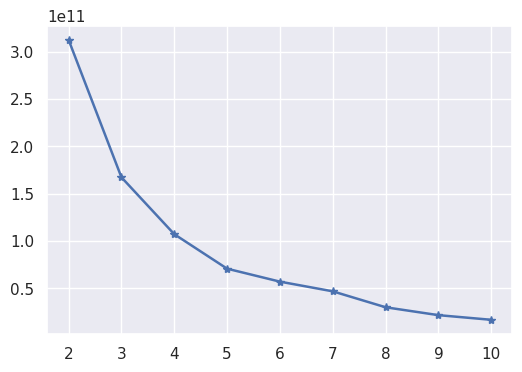

In [168]:
# Elbow Plot

plt.figure(figsize=(6,4))
plt.plot(range(2,11), inertia, marker = "*", linewidth = 1.8)

Taking 4 as the number of clusters as a parameter in Kmeans

In [169]:
k_model = KMeans(n_clusters = 5, init = "k-means++", max_iter = 1000)

In [170]:
k_model_fit = k_model.fit(new_df)

In [171]:
new_df

,predicted_purchases,expected_avg_sales_p,predicted_clv_p,profit_margin
0,0.469691,569.963180,6940.391335,347.019567
1,0.268854,333.111656,2300.084986,115.004249
2,0.561036,375.852105,5484.951958,274.247598
3,0.215241,323.118513,1774.640434,88.732022
4,0.250239,539.696607,3440.453870,172.022694
...,...,...,...,...
2785,0.554853,474.173916,6851.145204,342.557260
2786,0.260127,200.477296,1335.939943,66.796997
2787,0.281025,258.656258,1859.623136,92.981157
2788,1.021533,170.721018,4555.436385,227.771819


In [172]:
centers = k_model_fit.cluster_centers_

In [173]:
centers

array([[3.90291586e-01, 3.65949326e+02, 3.50722196e+03, 1.75361098e+02],
       [1.71849556e+00, 3.12016538e+04, 4.43665575e+05, 2.21832787e+04],
       [3.56971983e+00, 4.41244349e+03, 2.66911938e+05, 1.33455969e+04],
       [2.68357624e+00, 1.79381501e+03, 8.53779332e+04, 4.26889666e+03],
       [1.10756312e+00, 7.84239278e+02, 1.72754505e+04, 8.63772523e+02]])

In [174]:
labels = k_model_fit.labels_

In [175]:
labels = pd.Series(labels, name = "Labels")


In [176]:
ggf_filter = pd.concat([ggf_filter, labels], axis = 1)

In [177]:
#label_mapper = dict({0 : "Low", 3: "Medium", 1: "V_High", 2: "High",4: "V_Low"})
label_mapper = dict({0 : "V_Low", 3: "Medium", 1: "V_High", 2: "High", 4:"Low"})

In [178]:
ggf_filter["Labels"] = ggf_filter["Labels"].map(label_mapper)

In [179]:
ggf_filter.groupby("Labels").mean().T

Labels,High,Low,Medium,V_High,V_Low
CustomerID,1.460560e+04,1.496440e+04,1.542264e+04,1.639800e+04,1.531075e+04
frequency,4.600000e+01,1.247699e+01,3.804545e+01,2.333333e+01,3.295518e+00
recency,3.006000e+02,2.657615e+02,3.531818e+02,3.083333e+02,1.957842e+02
T,3.098000e+02,2.823808e+02,3.597273e+02,3.086667e+02,2.569849e+02
monetary_value,4.641204e+03,9.269529e+02,1.884810e+03,6.139526e+04,3.400167e+02
p_not_alive,1.690215e-09,2.061514e-08,2.617571e-09,4.056525e-11,2.516033e-08
p_alive,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
predicted_purchases,3.569720e+00,1.106213e+00,2.683576e+00,1.718496e+00,3.898506e-01
actual_purchases,4.520807e+00,1.761252e+00,3.165222e+00,1.976438e+00,7.912661e-01
expected_avg_sales_p,4.412443e+03,7.814375e+02,1.793815e+03,3.120165e+04,3.658831e+02


In [180]:
ggf_filter.head(10)

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual_purchases,expected_avg_sales_p,predicted_clv_p,profit_margin,Labels
0,12347.0,6.0,365.0,367.0,599.701667,2.319025e-10,1.0,0.469691,0.493151,569.963180,6940.391335,347.019567,V_Low
1,12348.0,3.0,283.0,358.0,301.480000,1.307946e-08,1.0,0.268854,0.318021,333.111656,2300.084986,115.004249,V_Low
2,12352.0,6.0,260.0,296.0,368.256667,6.432683e-09,1.0,0.561036,0.692308,375.852105,5484.951958,274.247598,V_Low
3,12356.0,2.0,303.0,325.0,269.905000,2.850083e-09,1.0,0.215241,0.198020,323.118513,1774.640434,88.732022,V_Low
4,12358.0,1.0,149.0,150.0,683.200000,1.401868e-10,1.0,0.250239,0.201342,539.696607,3440.453870,172.022694,V_Low
5,12359.0,3.0,274.0,331.0,1920.843333,9.313065e-09,1.0,0.286999,0.328467,1502.609442,11088.495453,554.424773,Low
6,12360.0,2.0,148.0,200.0,789.240000,9.662860e-09,1.0,0.315231,0.405405,652.437178,5294.383205,264.719160,V_Low
7,12362.0,9.0,292.0,295.0,527.458889,3.799225e-10,1.0,0.809777,0.924658,514.716999,10883.412217,544.170611,Low
8,12363.0,1.0,133.0,242.0,252.900000,2.184020e-08,1.0,0.176232,0.225564,339.928432,1510.701359,75.535068,V_Low
9,12364.0,3.0,105.0,112.0,229.726667,1.100878e-09,1.0,0.634103,0.857143,281.291683,4691.746292,234.587315,V_Low


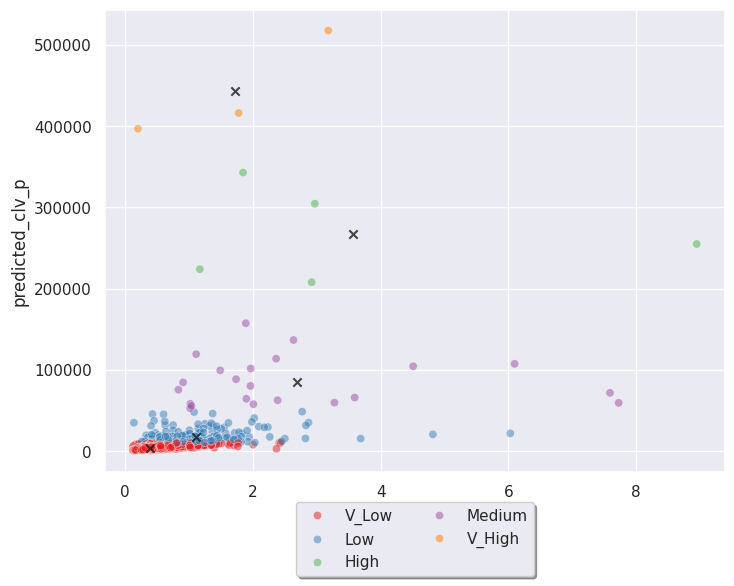

In [181]:
plt.figure(figsize=(8,6))
sns.scatterplot(x = "predicted_purchases", y = "predicted_clv_p", hue = "Labels", palette = "Set1", data = ggf_filter, alpha=0.5)
plt.scatter(centers[:, 0], centers[:, 2], marker = "x", color = "k", alpha = 0.8)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)

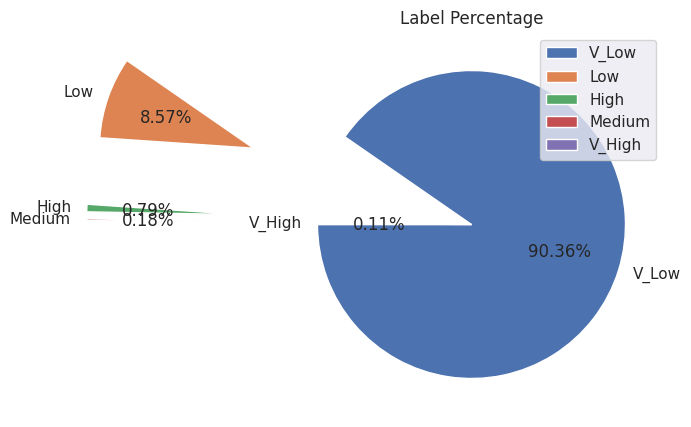

In [182]:
plt.figure(figsize=(5,5))
plt.pie(ggf_filter["Labels"].value_counts(), labels = ggf_filter["Labels"].unique(), startangle = 180, explode = [0.0,1.5,1.5,1.5,0.0], autopct = "%1.2f%%")
plt.title("Label Percentage")
plt.legend()

In [183]:
ggf_filter.to_csv("customer_segmentation_result.csv")

In [184]:
rfmt_data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


In [185]:
rfmt_data=rfmt_data.reset_index()

In [186]:
rfmt_data.columns

Index(['CustomerID', 'frequency', 'recency', 'T', 'monetary_value'], dtype='object')

In [187]:
# The data that is needed as input to the UI

rfmt_data.to_csv("RFM_Data")